<a href="https://colab.research.google.com/github/imi2201/Capstone-Project/blob/main/Model_2_Bangkit_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODEL 2

Image Classification With CNN

## Importing all lib


In [ ]:
from google.colab import drive
drive.mount('/content/driver/')


Drive already mounted at /content/driver/; to attempt to forcibly remount, call drive.mount("/content/driver/", force_remount=True).


In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tensorflow.keras import models, layers, optimizers, losses, metrics
from pathlib import Path


In [ ]:
local_zip = '/content/driver/MyDrive/Colab Notebooks/archive.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
# Specify the parent directory containing train and test subdirectories
train_dir = '/tmp/DATA/train'
test_dir = '/tmp/DATA/testing'

# Initialize counters
total_train_images = 0
total_test_images = 0

# Count images in train set
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Train - {category}: {num_images} images")
    total_train_images += num_images

# Count images in test set
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    num_images = len(os.listdir(category_dir))
    print(f"Test - {category}: {num_images} images")
    total_test_images += num_images

# Calculate total number of images
print(f"Total train images: {total_train_images}")
print(f"Total test images: {total_test_images}")

Train - Eczemaa: 88 images
Train - Actinic Keratosis: 88 images
Train - Basal Cell Carcinoma: 88 images
Train - Rosacea: 88 images
Train - Acne: 88 images
Test - Eczemaa: 37 images
Test - Actinic Keratosis: 37 images
Test - Basal Cell Carcinoma: 37 images
Test - Rosacea: 37 images
Test - Acne: 37 images
Total train images: 440
Total test images: 185


## Data Visualization

In [ ]:
# Train Data Classes
classes = os.listdir("/tmp/DATA/train")
classes = sorted(classes)
print(f"Total classes = {len(classes)}")
print(f"Classes: {classes}")

Total classes = 5
Classes: ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']


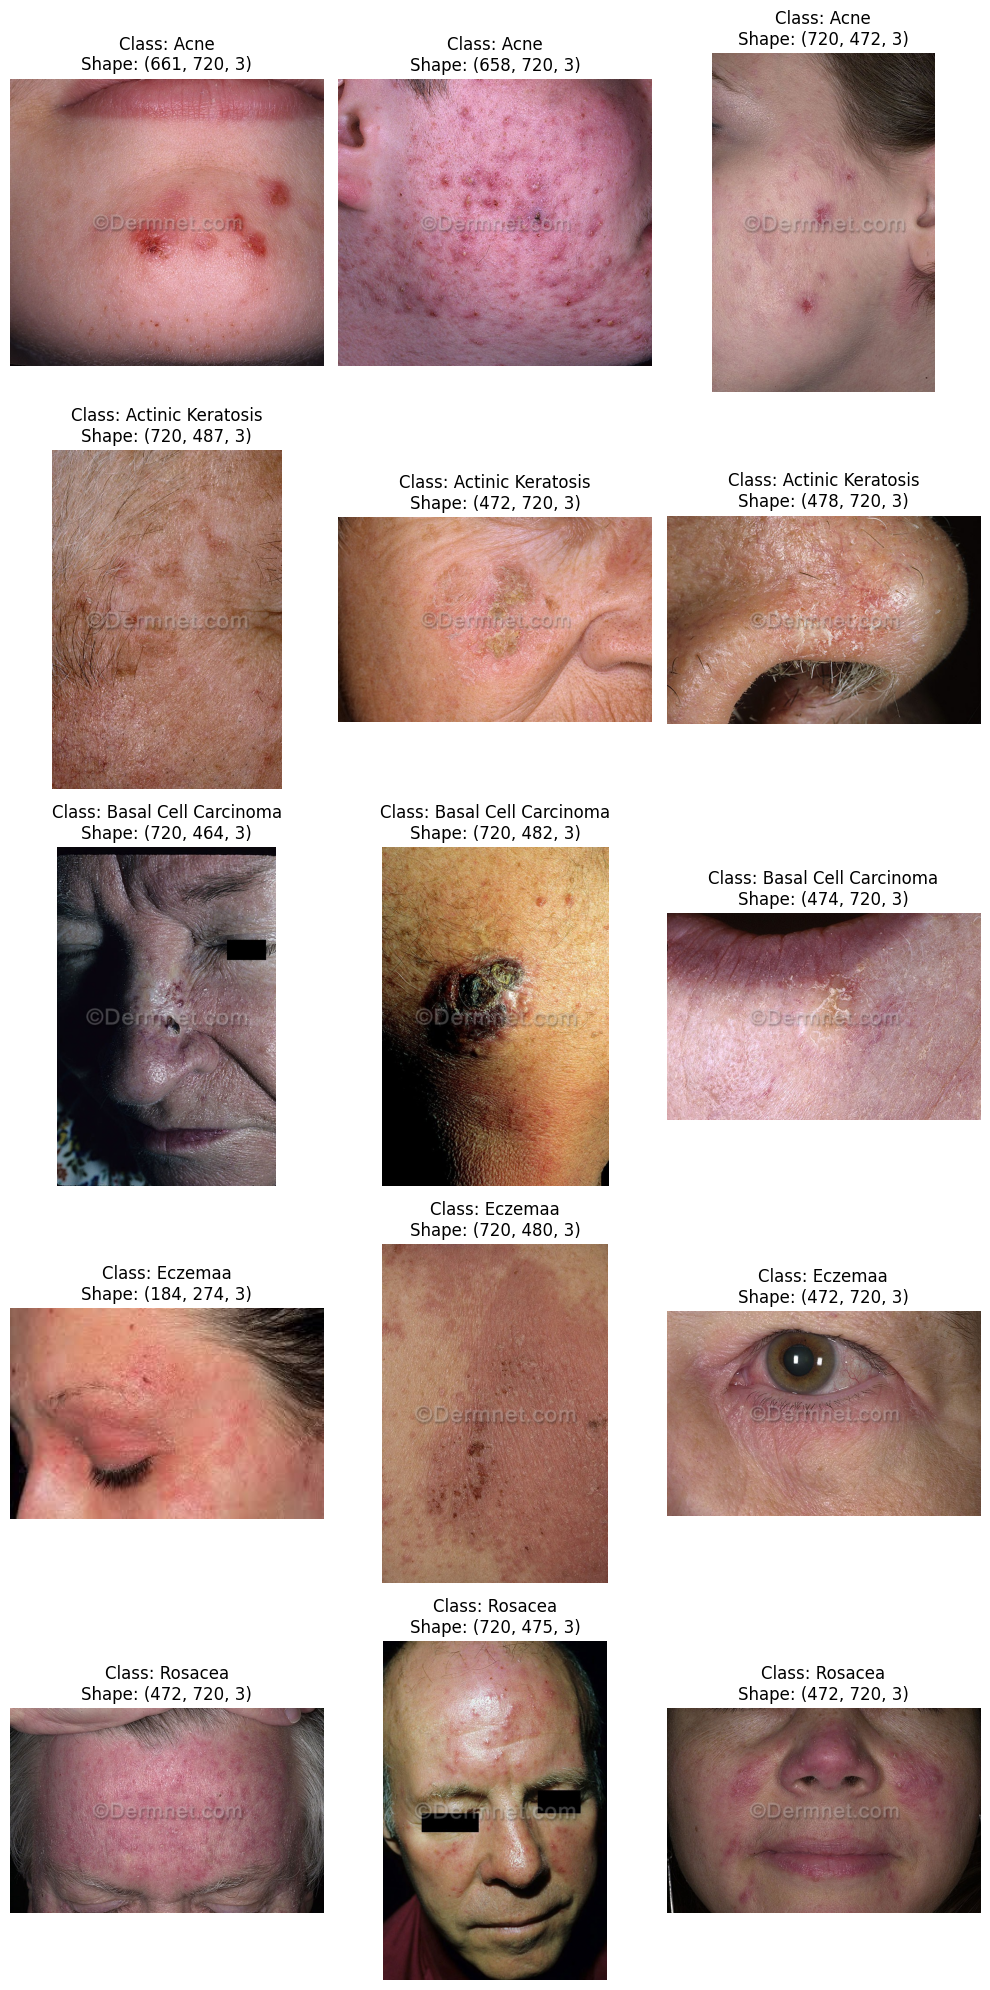

In [ ]:
# visualize some images from our training set.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10, 20))

p = 0

for c in classes:
    img_path_class = list(Path(os.path.join(train_dir,c)).glob("*.jpg"))
    img_selected = random.choices(img_path_class, k = NUM_IMAGES)
    for i,j in enumerate(img_selected):
        img_bgr = cv2.imread(str(j))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis('off')

    p += 1

fig.tight_layout()
fig.show()

In [ ]:
# Test Data Classes
classes = os.listdir("/tmp/DATA/testing")
classes = sorted(classes)
print(f"Total classes = {len(classes)}")
print(f"Classes: {classes}")

Total classes = 5
Classes: ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']


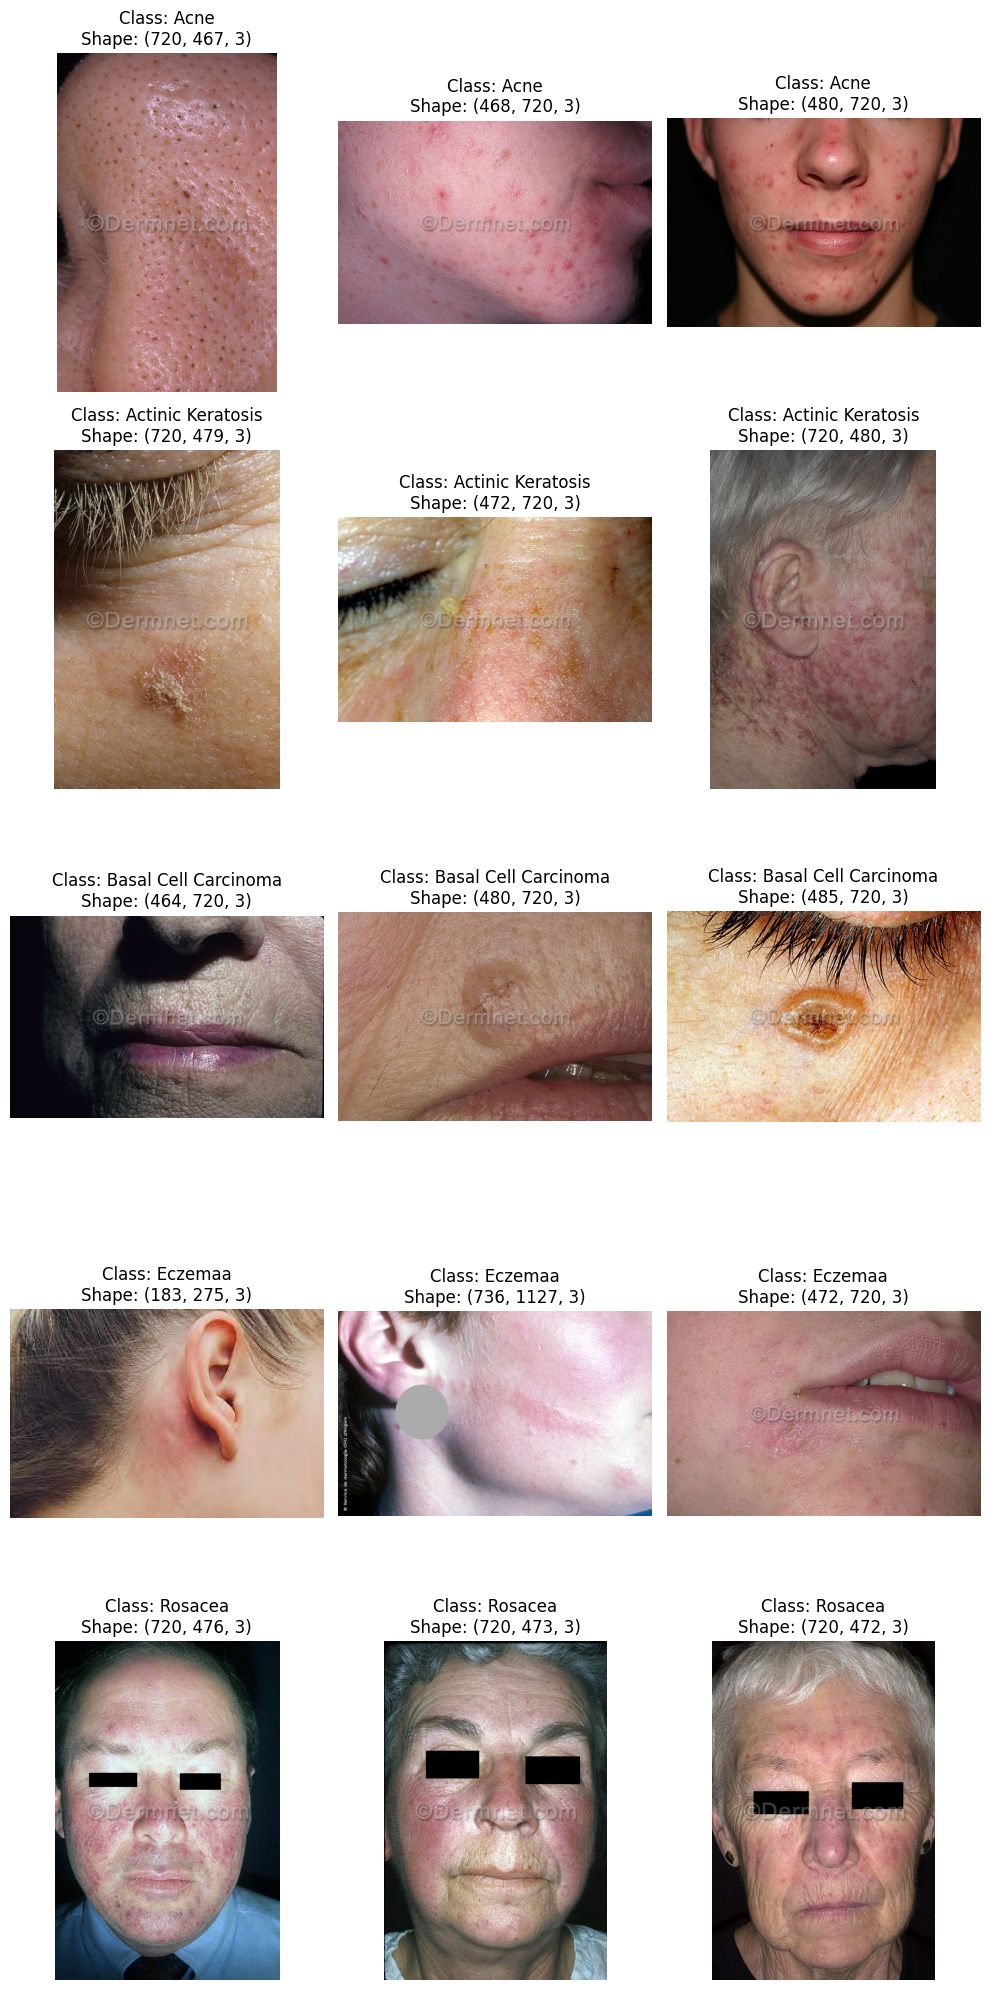

In [ ]:
# visualize some images from our testing set.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10, 20))

p = 0

for c in classes:
    img_path_class = list(Path(os.path.join(test_dir,c)).glob("*.jpg"))
    img_selected = random.choices(img_path_class, k = NUM_IMAGES)
    for i,j in enumerate(img_selected):
        img_bgr = cv2.imread(str(j))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}")
        ax[p,i].axis('off')

    p += 1

fig.tight_layout()
fig.show()

In [ ]:
# Define your data directory
data_dir = '/tmp/DATA'

# List all class subdirectories
class_subdirs = os.listdir(data_dir)

# Initialize empty lists for images and labels
train_images = []
train_labels = []

# Load images and labels
for class_subdir in class_subdirs:
    class_path = os.path.join(data_dir, class_subdir)
    class_images = os.listdir(class_path)
    for image_filename in class_images:
        image_path = os.path.join(class_path, image_filename)
        image = cv2.imread(image_path)  # Read the image using OpenCV (adjust as needed)
        train_images.append(image)
        train_labels.append(class_subdir)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Normalize pixel values (if not already done)
train_images = train_images.astype('float32') / 255


In [ ]:
# Paths
base_dir = '/tmp/DATA'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Create validation directory
os.makedirs(validation_dir, exist_ok=True)

# Move a portion of train data to validation directory
validation_split = 0.2  # 20% for validation

for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(validation_dir, class_name)
    os.makedirs(class_val_dir, exist_ok=True)

    images = os.listdir(class_train_dir)
    random.shuffle(images)

    val_count = int(len(images) * validation_split)
    val_images = images[:val_count]
    train_images = images[val_count:]

    # Move images to validation directory
    for img in val_images:
        shutil.move(os.path.join(class_train_dir, img), os.path.join(class_val_dir, img))



In [ ]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Train Data Generator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 355 images belonging to 5 classes.
Found 85 images belonging to 5 classes.


In [ ]:
# Data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 185 images belonging to 5 classes.


In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Create an instance of the model
model = create_model()

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=75,
    validation_data=validation_generator
)

Epoch 1/75
12/12 [==============================] - 4s 150ms/step - loss: 15.1590 - accuracy: 0.2676 - val_loss: 2.4080 - val_accuracy: 0.1647
Epoch 2/75
12/12 [==============================] - 2s 130ms/step - loss: 5.6039 - accuracy: 0.4000 - val_loss: 2.5710 - val_accuracy: 0.1765
Epoch 3/75
12/12 [==============================] - 2s 138ms/step - loss: 4.0864 - accuracy: 0.4789 - val_loss: 3.5090 - val_accuracy: 0.2000
Epoch 4/75
12/12 [==============================] - 3s 216ms/step - loss: 3.2598 - accuracy: 0.5099 - val_loss: 2.8119 - val_accuracy: 0.2235
Epoch 5/75
12/12 [==============================] - 2s 149ms/step - loss: 2.7886 - accuracy: 0.6000 - val_loss: 4.1735 - val_accuracy: 0.2000
Epoch 6/75
12/12 [==============================] - 2s 125ms/step - loss: 1.9920 - accuracy: 0.6338 - val_loss: 3.6929 - val_accuracy: 0.2000
Epoch 7/75
12/12 [==============================] - 2s 127ms/step - loss: 2.1035 - accuracy: 0.6169 - val_loss: 4.2962 - val_accuracy: 0.2000
Epoch

6/6 [==============================] - 1s 105ms/step - loss: 3.4843 - accuracy: 0.6000
Test accuracy: 0.6000000238418579


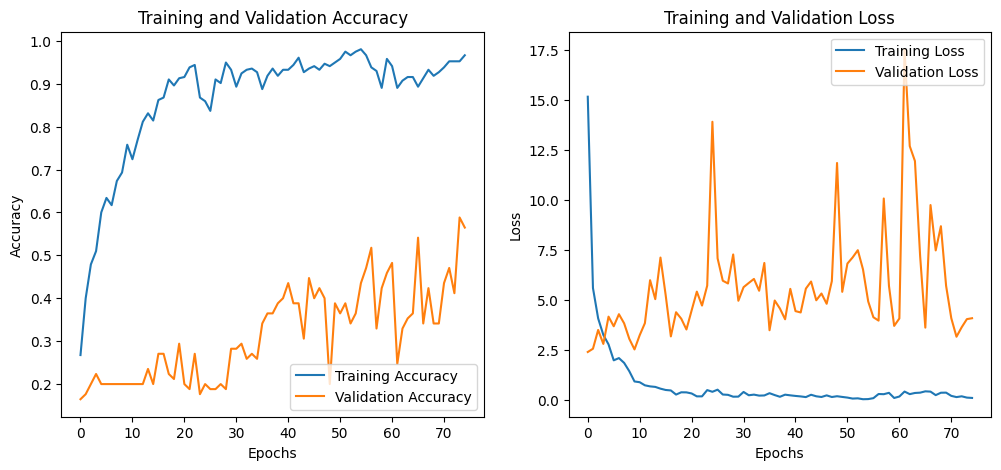

In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

# Plotting training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()